# One-dimensional regression

## Setup

Loading the necessary packages and setting seed.

In [1]:
using AbstractGPs
using Distributions
using StatsFuns

using Plots
default(legend=:outertopright, size=(700,400))

using Random
Random.seed!(1234)

MersenneTwister(1234)

Load toy regression
[dataset](https://github.com/GPflow/docs/blob/master/doc/source/notebooks/basics/data/regression_1D.csv)
taken from GPFlow examples.

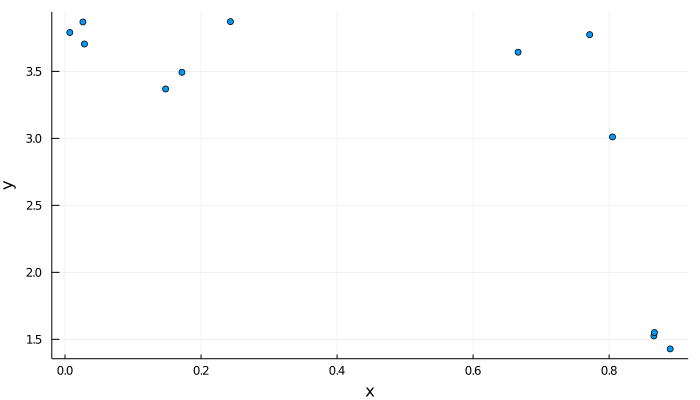

In [2]:
x = [0.8658165855998895, 0.6661700880180962, 0.8049218148148531, 0.7714303440386239,
    0.14790478354654835, 0.8666105548197428, 0.007044577166530286, 0.026331737288148638,
    0.17188596617099916, 0.8897812990554013, 0.24323574561119998, 0.028590102134105955]
y = [1.5255314337144372, 3.6434202968230003, 3.010885733911661, 3.774442382979625,
    3.3687639483798324, 1.5506452040608503, 3.790447985799683, 3.8689707574953,
    3.4933565751758713, 1.4284538820635841, 3.8715350915692364, 3.7045949061144983]
scatter(x, y; xlabel="x", ylabel="y", legend=false)

We split the observations into train and test data.

In [3]:
x_train = x[1:8]
y_train = y[1:8]
x_test = x[9:end]
y_test = y[9:end]

4-element Vector{Float64}:
 3.4933565751758713
 1.4284538820635841
 3.8715350915692364
 3.7045949061144983

We instantiate a Gaussian process with a Matern kernel. The kernel has
fixed variance and length scale parameters of default value 1.

In [4]:
f = GP(Matern52Kernel())

GP{AbstractGPs.ZeroMean{Float64}, Matern52Kernel}(AbstractGPs.ZeroMean{Float64}(), Matern 5/2 Kernel)

We create a finite dimentional projection at the inputs of the training dataset
observed under Gaussian noise with standard deviation $\sigma = 0.1$, and compute the
log-likelihood of the outputs of the training dataset.

In [5]:
fx = f(x_train, 0.1)
logpdf(fx, y_train)

-25.53057444906227

We compute the posterior Gaussian process given the training data, and calculate the
log-likelihood of the test dataset.

In [6]:
p_fx = posterior(fx, y_train)
logpdf(p_fx(x_test), y_test)

-232.51565975751606

We plot the posterior Gaussian process along with the observations.

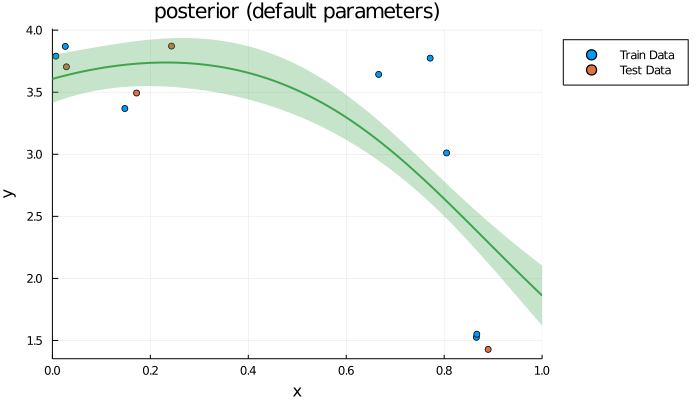

In [7]:
scatter(
    x_train, y_train;
    xlim=(0,1), xlabel="x", ylabel="y",
    title="posterior (default parameters)", label="Train Data",
)
scatter!(x_test, y_test; label="Test Data")
plot!(p_fx, 0:0.001:1; label=false)

## Markov Chain Monte Carlo

Previously we computed the log likelihood of the untuned kernel parameters of the GP.
We now also perform approximate inference over said kernel parameters using different
Markov chain Monte Carlo (MCMC) methods. I.e., we approximate the posterior distribution
of the kernel parameters with samples from a Markov chain.

We define a function which returns the log-likelihood of the data for different variance
and inverse lengthscale parameters of the Matern kernel. We ensure that these parameters are
positive with the softplus function
$$
f(x) = \log (1 + \exp x).
$$

In [8]:
struct GPLoglikelihood{X,Y}
    x::X
    y::Y
end

function (ℓ::GPLoglikelihood)(params)
    kernel = ScaledKernel(
        transform(
            Matern52Kernel(),
            ScaleTransform(softplus(params[1]))
        ),
        softplus(params[2]),
    )
    f = GP(kernel)
    fx = f(ℓ.x, 0.1)
    return logpdf(fx, ℓ.y)
end

const loglik_train = GPLoglikelihood(x_train, y_train)

Main.##258.GPLoglikelihood{Vector{Float64}, Vector{Float64}}([0.8658165855998895, 0.6661700880180962, 0.8049218148148531, 0.7714303440386239, 0.14790478354654835, 0.8666105548197428, 0.007044577166530286, 0.026331737288148638], [1.5255314337144372, 3.6434202968230003, 3.010885733911661, 3.774442382979625, 3.3687639483798324, 1.5506452040608503, 3.790447985799683, 3.8689707574953])

We define a Gaussian prior for the joint distribution of the two transformed kernel
parameters. We assume that both parameters are independent with mean 0 and variance 1.

In [9]:
logprior(params) = logpdf(MvNormal(2, 1), params)

logprior (generic function with 1 method)

### Hamiltonian Monte Carlo

We start with a Hamiltonian Monte Carlo (HMC) sampler. More precisely, we use the
[No-U-Turn sampler (NUTS)](http://www.jmlr.org/papers/volume15/hoffman14a/hoffman14a.pdf),
which is provided by the Julia packages
[AdvancedHMC.jl](https://github.com/TuringLang/AdvancedHMC.jl/) and
[DynamicHMC.jl](https://github.com/tpapp/DynamicHMC.jl/).

#### AdvancedHMC

We start with performing inference with AdvancedHMC.

In [10]:
using AdvancedHMC
using ForwardDiff

Set the number of samples to draw and warmup iterations.

In [11]:
n_samples = 2_000
n_adapts = 1_000

1000

Define a Hamiltonian system of the log joint probability.

In [12]:
logjoint_train(params) = loglik_train(params) + logprior(params)
metric = DiagEuclideanMetric(2)
hamiltonian = Hamiltonian(metric, logjoint_train, ForwardDiff)

Hamiltonian(metric=DiagEuclideanMetric([1.0, 1.0]))

Define a leapfrog solver, with initial step size chosen heuristically.

In [13]:
initial_params = rand(2)
initial_ϵ = find_good_stepsize(hamiltonian, initial_params)
integrator = Leapfrog(initial_ϵ)

Leapfrog(ϵ=3.2)

Define an HMC sampler, with the following components:
- multinomial sampling scheme,
- generalised No-U-Turn criteria, and
- windowed adaption for step-size and diagonal mass matrix

In [14]:
proposal = NUTS{MultinomialTS, GeneralisedNoUTurn}(integrator)
adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))

StanHMCAdaptor(
    pc=WelfordVar,
    ssa=NesterovDualAveraging(γ=0.05, t_0=10.0, κ=0.75, δ=0.8, state.ϵ=3.2),
    init_buffer=75, term_buffer=50, window_size=25,
    state=window(0, 0), window_splits()
)

We draw samples from the posterior distribution of kernel parameters. These samples
are in the unconstrained space $\mathbb{R}^2$.

In [15]:
samples, _ = sample(
    hamiltonian,
    proposal,
    initial_params,
    n_samples,
    adaptor,
    n_adapts;
    progress=false,
)

┌ Info: Finished 1000 adapation steps
│   adaptor = StanHMCAdaptor(
    pc=WelfordVar,
    ssa=NesterovDualAveraging(γ=0.05, t_0=10.0, κ=0.75, δ=0.8, state.ϵ=0.7900421922233165),
    init_buffer=75, term_buffer=50, window_size=25,
    state=window(76, 950), window_splits(100, 150, 250, 450, 950)
)
│   τ.integrator = Leapfrog(ϵ=0.79)
│   h.metric = DiagEuclideanMetric([0.4190177746701299, 0.4630 ...])
└ @ AdvancedHMC /home/runner/.julia/packages/AdvancedHMC/MIxdK/src/sampler.jl:188
┌ Info: Finished 2000 sampling steps for 1 chains in 1.558610214 (s)
│   h = Hamiltonian(metric=DiagEuclideanMetric([0.4190177746701299, 0.4630 ...]))
│   τ = NUTS{MultinomialTS,Generalised}(integrator=Leapfrog(ϵ=0.79), max_depth=10), Δ_max=1000.0)
│   EBFMI_est = 1.0656823753088982
│   average_acceptance_rate = 0.8612527628343132
└ @ AdvancedHMC /home/runner/.julia/packages/AdvancedHMC/MIxdK/src/sampler.jl:207


([[0.5908446386657102, 0.7667970365022592], [0.5908446386657102, 0.7667970365022592], [1.234192318772796, 1.7033239496380101], [1.5589388498228376, 2.030498269416919], [1.5589388498228376, 2.030498269416919], [1.643290322716593, 2.1052617655805026], [1.8087873426454064, 2.1791390289258095], [2.448387587450342, 2.379089803777005], [3.0133637048641053, 2.928334189542872], [1.5661363058212046, 1.4903183311695132]  …  [2.4060327604033187, 0.9360722761420174], [1.0626939698419577, 3.1825748775458873], [1.92138818224449, 2.981035295322456], [2.2924637593024295, 2.1032264874458524], [1.9396029584628285, 1.802813499186731], [1.8164282528203277, 2.9356389534241174], [2.324932020813646, 2.4370138834701973], [2.0065315511199877, 3.1251719599807193], [2.706779608894903, 3.100681675846752], [1.4161747120124806, 1.8265313601940258]], NamedTuple[(n_steps = 1, is_accept = true, acceptance_rate = 1.3643605570839266e-273, log_density = -26.750062521655238, hamiltonian_energy = 26.92892758121242, hamilto

We transform the samples back to the constrained space and compute the mean of both
parameters:

In [16]:
samples_constrained = [map(softplus, p) for p in samples]
mean_samples = mean(samples_constrained)

2-element Vector{Float64}:
 2.224006671784089
 2.3283919081052535

We plot a histogram of the samples for the two parameters.
The vertical line in each graph indicates the mean of the samples.

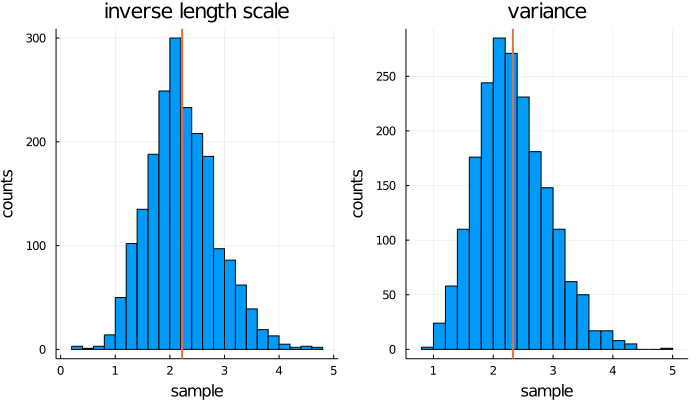

In [17]:
histogram(
    reduce(hcat, samples_constrained)';
    xlabel="sample", ylabel="counts", layout=2,
    title=["inverse length scale" "variance"], legend=false,
)
vline!(mean_samples'; linewidth=2)

We approximate the log-likelihood of the test data using the posterior Gaussian processes
for kernels with the sampled kernel parameters. We can observe that there is a significant
improvement over the log-likelihood of the test data with respect to the posterior
Gaussian process with default kernel parameters of value 1.

In [18]:
struct GPPosterior{X,Y}
    x::X
    y::Y
end

function (g::GPPosterior)(p)
    kernel = ScaledKernel(
        transform(
            Matern52Kernel(),
            ScaleTransform(softplus(p[1]))
        ),
        softplus(p[2]),
    )
    f = GP(kernel)
    return posterior(f(g.x, 0.1), g.y)
end

const gp_posterior = GPPosterior(x_train, y_train)

mean(logpdf(gp_posterior(p)(x_test), y_test) for p in samples)

-45.602720491386634

We sample a function from the posterior GP for the final 100 samples of kernel
parameters.

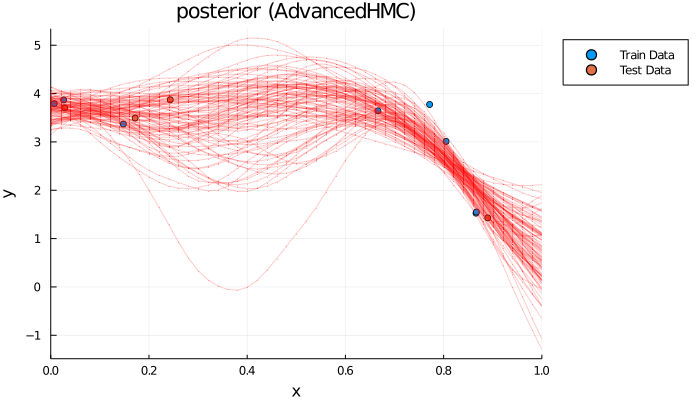

In [19]:
plt = scatter(
    x_train, y_train;
    xlim=(0,1), xlabel="x", ylabel="y",
    title="posterior (AdvancedHMC)", label="Train Data",
)
scatter!(plt, x_test, y_test; label="Test Data")
for p in samples[(end-100):end]
    sampleplot!(plt, gp_posterior(p)(0:0.02:1), 1)
end
plt

#### DynamicHMC

We repeat the inference with DynamicHMC.

In [20]:
using DynamicHMC
using LogDensityProblems

We have to implement the LogDensityProblems interface for `GPLogLikelihood`.

In [21]:
# Log joint density
LogDensityProblems.logdensity(ℓ::GPLoglikelihood, params) = ℓ(params) + logprior(params)

# The parameter space is two-dimensional
LogDensityProblems.dimension(::GPLoglikelihood) = 2

# `GPLoglikelihood` does not allow to evaluate derivatives of
# the log-likelihood function
function LogDensityProblems.capabilities(::Type{<:GPLoglikelihood})
    LogDensityProblems.LogDensityOrder{0}()
end

Now we can draw samples from the posterior distribution of kernel parameters with
DynamicHMC. Again we use [ForwardDiff.jl](https://github.com/JuliaDiff/ForwardDiff.jl)
to compute the derivatives of the log joint density with automatic differentiation.

In [22]:
samples = mcmc_with_warmup(
    Random.GLOBAL_RNG,
    ADgradient(:ForwardDiff, loglik_train),
    n_samples;
    reporter = NoProgressReport(),
).chain

2000-element Vector{Vector{Float64}}:
 [2.1027654309134345, 2.7615876554655907]
 [2.184422367215484, 1.9460038228741618]
 [2.606955094357974, 1.9956725099914085]
 [2.755273536110505, 1.9236184403517522]
 [2.858094301615456, 1.7820684433406355]
 [2.5612616332704614, 1.564451089513363]
 [2.5243151132019, 2.3962841869471063]
 [2.9718399175109873, 1.873643544856686]
 [2.155012427434551, 1.4757668498475929]
 [2.240634513122058, 2.840796587955707]
 ⋮
 [1.2784679079762542, 2.4748380755994157]
 [3.5615461526332615, 1.8779975909363908]
 [1.2835385471666418, 2.560887761205259]
 [3.0807034514248044, 2.513474664865035]
 [2.3927059381140836, 3.3065118911046265]
 [2.341723947736955, 3.293946303230604]
 [2.6017545389168513, 3.4110996688437276]
 [2.7619407554571627, 1.692314549104298]
 [2.64267198087384, 1.3964963661689969]

We transform the samples back to the constrained space and compute the mean of both
parameters:

In [23]:
samples_constrained = [map(softplus, p) for p in samples]
mean_samples = mean(samples_constrained)

2-element Vector{Float64}:
 2.270225899672642
 2.3240024451956462

We plot a histogram of the samples for the two parameters.
The vertical line in each graph indicates the mean of the samples.

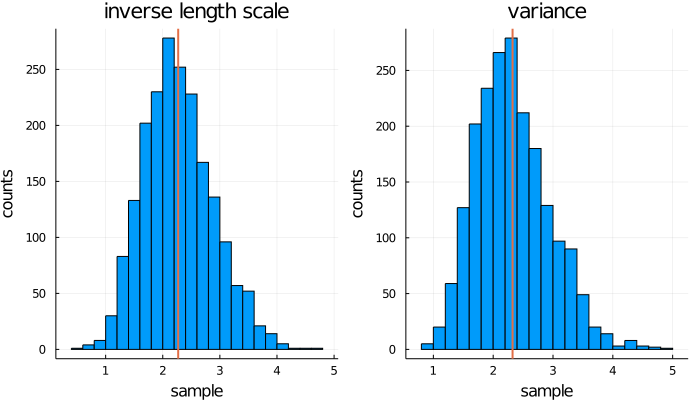

In [24]:
histogram(
    reduce(hcat, samples_constrained)';
    xlabel="sample", ylabel="counts", layout=2,
    title=["inverse length scale" "variance"], legend=false,
)
vline!(mean_samples'; linewidth=2)

Again we can observe that there is a significant improvement over the log-likelihood
of the test data with respect to the posterior Gaussian process with default kernel
parameters.

In [25]:
mean(logpdf(gp_posterior(p)(x_test), y_test) for p in samples)

-8.88721997318576

We sample a function from the posterior GP for the final 100 samples of kernel
parameters.

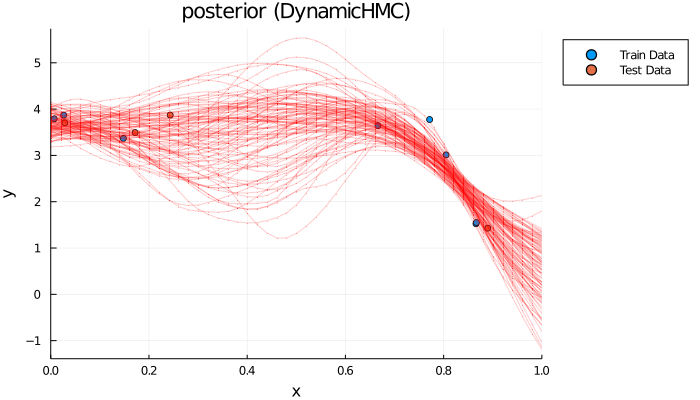

In [26]:
plt = scatter(
    x_train, y_train;
    xlim=(0,1), xlabel="x", ylabel="y",
    title="posterior (DynamicHMC)", label="Train Data",
)
scatter!(plt, x_test, y_test; label="Test Data")
for p in samples[(end-100):end]
    sampleplot!(plt, gp_posterior(p)(0:0.02:1), 1)
end
plt

### Elliptical slice sampling

Instead of HMC, we use
[elliptical slice sampling](http://proceedings.mlr.press/v9/murray10a/murray10a.pdf)
which is provided by the Julia package
[EllipticalSliceSampling.jl](https://github.com/TuringLang/EllipticalSliceSampling.jl/).

In [27]:
using EllipticalSliceSampling

We draw 2000 samples from the posterior distribution of kernel parameters.

In [28]:
samples = sample(
    ESSModel(
        MvNormal(2, 1), # Gaussian prior
        loglik_train,
    ),
    ESS(),
    n_samples;
    progress=false,
)

2000-element Vector{Vector{Float64}}:
 [0.034783019851225165, -0.6095175256750726]
 [-1.0107605156942916, -0.06883264732330961]
 [-0.6024774737030231, 0.3798905420709041]
 [1.6232699250771914, 0.4186622011371979]
 [0.91359108868965, 0.9326589725562934]
 [0.8405883168836435, 0.9524309513632424]
 [1.4147325764616303, 0.6507514268006351]
 [0.7791556357860482, 1.236987990021495]
 [0.6428929661946357, 1.1923691648618366]
 [0.5114471339455826, 1.0402812849063425]
 ⋮
 [1.3561586520334101, 2.7989964960170433]
 [1.2074190326757401, 3.45404644177549]
 [1.624563858693854, 3.3427544226550516]
 [1.7923251061712462, 3.343487574793196]
 [1.8771049163113567, 3.3285905048565816]
 [1.8409817726621158, 3.296632953799603]
 [1.6077392547712073, 3.4182232689563543]
 [2.498257842310339, 2.913223332322175]
 [2.491323688431356, 2.8806331007400554]

We transform the samples back to the constrained space and compute the mean of both
parameters:

In [29]:
samples_constrained = [map(softplus, p) for p in samples]
mean_samples = mean(samples_constrained)

2-element Vector{Float64}:
 2.3254344525784236
 2.3378813752066105

We plot a histogram of the samples for the two parameters.
The vertical line in each graph indicates the mean of the samples.

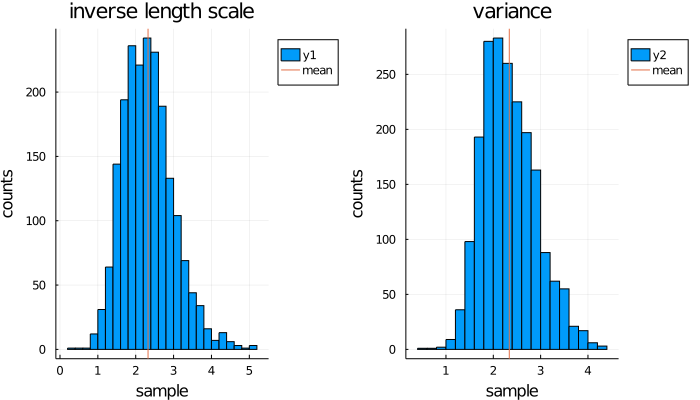

In [30]:
histogram(
    reduce(hcat, samples_constrained)';
    xlabel="sample", ylabel="counts", layout=2,
    title=["inverse length scale" "variance"],
)
vline!(mean_samples'; layout=2, labels="mean")

Again we can observe that there is a significant improvement over the log-likelihood
of the test data with respect to the posterior Gaussian process with default kernel
parameters.

In [31]:
mean(logpdf(gp_posterior(p)(x_test), y_test) for p in samples)

-43.89733740518967

We sample a function from the posterior GP for the final 100 samples of kernel
parameters.

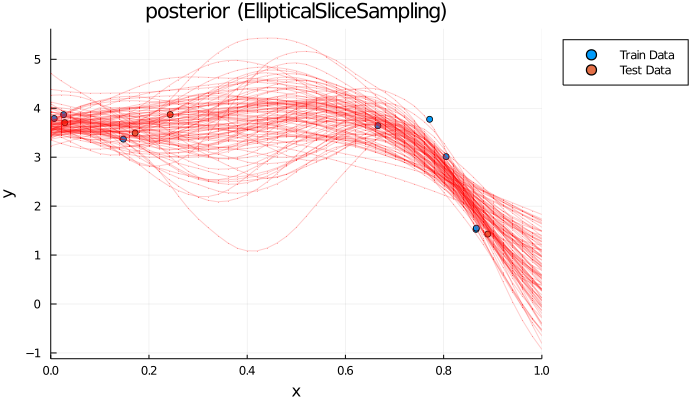

In [32]:
plt = scatter(
    x_train, y_train;
    xlim=(0,1), xlabel="x", ylabel="y",
    title="posterior (EllipticalSliceSampling)", label="Train Data",
)
scatter!(plt, x_test, y_test; label="Test Data")
for p in samples[(end-100):end]
    sampleplot!(plt, gp_posterior(p)(0:0.02:1), 1)
end
plt

## Variational Inference

Sanity check for the Evidence Lower BOund (ELBO) implemented according to
M. K. Titsias's _Variational learning of inducing variables in sparse Gaussian processes_.

In [33]:
elbo(fx, y_train, f(rand(5)))

-25.606576383821693

We use the LBFGS algorithm to maximize the given ELBO. It is provided by the Julia
package [Optim.jl](https://github.com/JuliaNLSolvers/Optim.jl).

In [34]:
using Optim

We define a function which returns the negative ELBO for different variance and inverse
lengthscale parameters of the Matern kernel and different pseudo-points. We ensure that
the kernel parameters are positive with the softplus function
$$
f(x) = \log (1 + \exp x),
$$
and that the pseudo-points are in the unit interval $[0,1]$ with the logistic function
$$
f(x) = \frac{1}{1 + \exp{(-x)}}.
$$

In [35]:
struct NegativeELBO{X,Y}
    x::X
    y::Y
end

function (g::NegativeELBO)(params)
    kernel = ScaledKernel(
        transform(
            Matern52Kernel(),
            ScaleTransform(softplus(params[1]))
        ),
        softplus(params[2]),
    )
    f = GP(kernel)
    fx = f(g.x, 0.1)
    return -elbo(fx, g.y, f(logistic.(params[3:end])))
end

We randomly initialize the kernel parameters and 5 pseudo points, and minimize the
negative ELBO with the LBFGS algorithm and obtain the following optimal parameters:

In [36]:
x0 = rand(7)
opt = optimize(NegativeELBO(x_train, y_train), x0, LBFGS())

 * Status: success

 * Candidate solution
    Final objective value:     1.086921e+01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 3.34e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.98e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.68e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.23e-15 ≰ 0.0e+00
    |g(x)|                 = 9.39e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    81
    f(x) calls:    207
    ∇f(x) calls:   207


In [37]:
opt.minimizer

7-element Vector{Float64}:
  3.9327313160489554
  8.37938075104705
  0.6917110603002495
  1.276311224895199
 -4.133675592793611
 -1.7583272848613252
  1.8479534825819126

The optimized value of the inverse lengthscale is

In [38]:
softplus(opt.minimizer[1])

3.9521319926522613

and of the variance is

In [39]:
softplus(opt.minimizer[2])

8.379610276755328

We compute the log-likelihood of the test data for the resulting approximate
posterior. We can observe that there is a significant improvement over the
log-likelihood with the default kernel parameters of value 1.

In [40]:
opt_kernel = ScaledKernel(
    transform(
        Matern52Kernel(),
        ScaleTransform(softplus(opt.minimizer[1]))
    ),
    softplus(opt.minimizer[2]),
)
opt_f = GP(opt_kernel)
opt_fx = opt_f(x_train, 0.1)
ap = approx_posterior(VFE(), opt_fx, y_train, opt_f(logistic.(opt.minimizer[3:end])))
logpdf(ap(x_test), y_test)

-1.0521977468146746

We visualize the approximate posterior with optimized parameters.

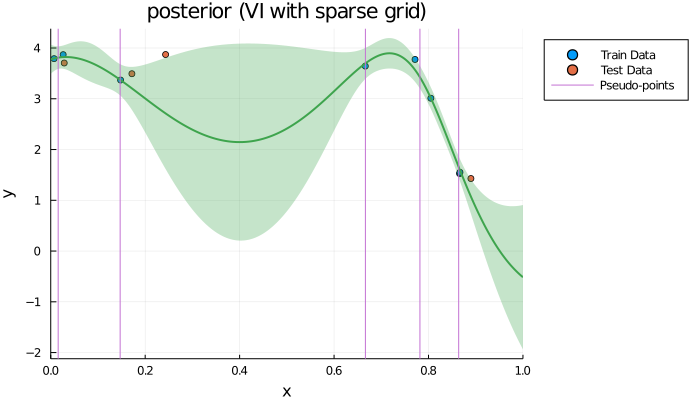

In [41]:
scatter(
    x_train, y_train;
    xlim=(0,1), xlabel="x", ylabel="y",
    title="posterior (VI with sparse grid)", label="Train Data",
)
scatter!(x_test, y_test; label="Test Data")
plot!(ap, 0:0.001:1; label=false)
vline!(logistic.(opt.minimizer[3:end]); label="Pseudo-points")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*